# Voice conversion prototyping

with GMMs; Arctic corpus

In [1]:
# open data
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~"), "Documents/em_lct/UoM/thesis/data/", "arctic")
!ls $DATA_ROOT

cmu_us_awb_arctic cmu_us_clb_arctic


In [2]:
# nnmnkwii imports taken from example notebook on VC
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os import listdir
from os.path import basename, splitext, join, splitext, isdir
import sys
import time

import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


/Users/kennylino/.local/share/virtualenvs/thesis-W2ZHkp3l/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 30 # number of utterances to be used.
test_size = 0.33
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [4]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=42)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        x, frame_sample = librosa.load(path, sr=fs, dtype=float64)
        f0, timeaxis = pyworld.dio(x, frame_sample, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, frame_sample)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, frame_sample)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [5]:
src_speaker = MyFileDataSource(data_root=DATA_ROOT, speakers=["awb"], max_files=max_files) # This is actually speaker TNI from Arctic L2
tgt_speaker = MyFileDataSource(data_root=DATA_ROOT, speakers=["clb"], max_files=max_files) 

In [6]:
# convert training sets into arrays
X = PaddedFileSourceDataset(src_speaker, 1200).asarray()
Y = PaddedFileSourceDataset(tgt_speaker, 1200).asarray()
print(X.shape)
print(Y.shape) 
# shape = (13 training audios, 2800 frames, 25 features per frame)

(20, 1200, 25)
(20, 1200, 25)


In [7]:
src_speaker.test_paths

['/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0028.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0016.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0024.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0018.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0009.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0010.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0029.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0025.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0013.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_awb_arctic/wav/arctic_a0001.wav']

In [8]:
tgt_speaker.test_paths

['/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0028.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0016.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0024.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0018.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0009.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0010.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0029.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0025.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0013.wav',
 '/Users/kennylino/Documents/em_lct/UoM/thesis/data/arctic/cmu_us_clb_arctic/wav/arctic_a0001.wav']

In [9]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

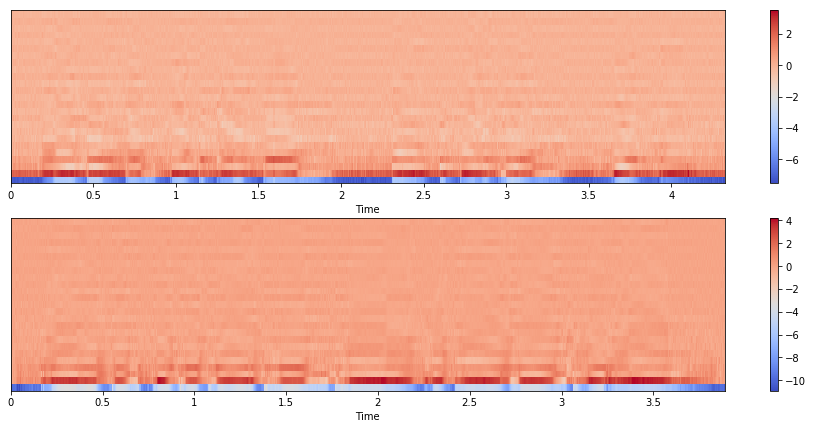

In [10]:
idx = 6 # any 
plot_parallel(X[idx],Y[idx])

In [11]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

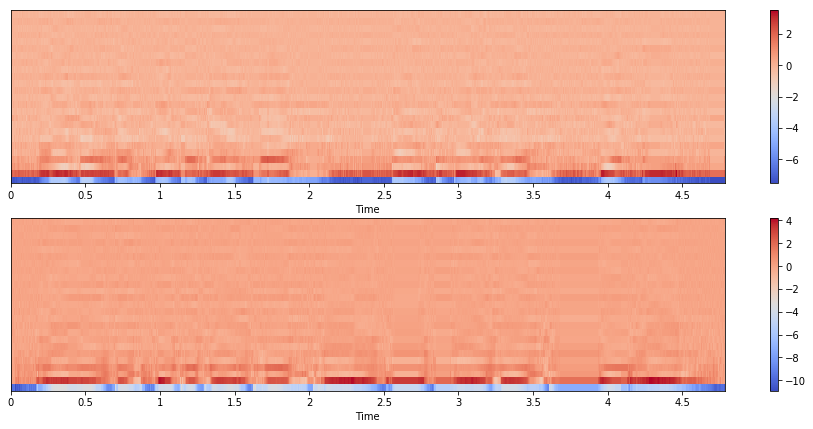

In [12]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [13]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [14]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

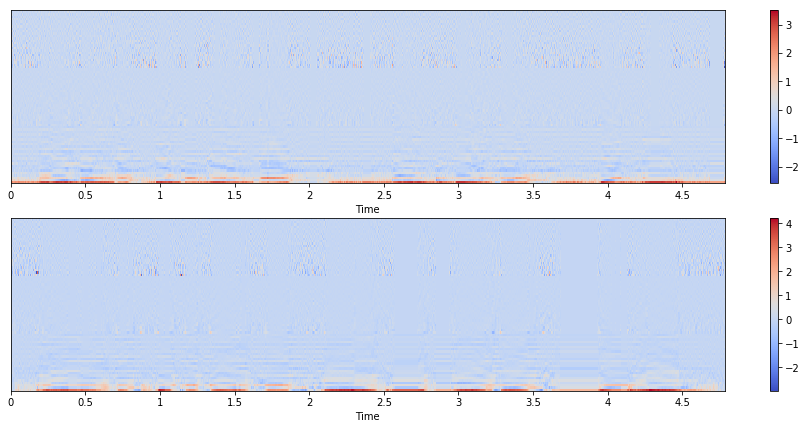

In [15]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

## Kmeans clustering of MFCC feature vectors

### clustering of source speaker

In [16]:
km_X = KMeans(n_clusters=512, init='k-means++', max_iter=100, n_init=1)

In [17]:
X_aligned.shape

(20, 1266, 72)

In [18]:
# concatenates all of the frames in each sentence since k-means needs one large vector
all_frames_X = numpy.concatenate(X_aligned, axis=0)

In [19]:
# should equal number of frames * number of utterances
len(all_frames_X)

25320

In [20]:
all_frames_X.shape

(25320, 72)

In [21]:
all_frames_X[0]

array([ 1.42554200e+00,  6.94959611e-02,  8.49967182e-01,  5.30471087e-01,
       -5.16656451e-02,  9.50899869e-02, -3.65642339e-01, -5.94442338e-03,
       -2.22362764e-02, -1.69607565e-01,  1.12864837e-01, -3.47930901e-02,
       -1.85421873e-02,  6.19901493e-02, -1.03788957e-01,  1.34903356e-01,
       -1.28760472e-01,  9.06630382e-02, -1.92599203e-02, -1.89942755e-02,
        4.18269075e-02, -2.39720400e-02, -2.84292060e-03,  1.44430650e-02,
        5.82650959e-01, -1.30695939e-01,  2.53207445e-01,  1.79581568e-01,
        4.87817600e-02, -5.41032292e-02,  8.33999738e-02, -1.15976728e-01,
       -1.10846639e-01,  1.01503417e-01,  3.27799506e-02, -1.15184598e-01,
        8.46790895e-02, -5.68445921e-02,  6.09021559e-02, -7.06803352e-02,
        6.61784783e-02, -7.26548731e-02,  6.03104308e-02, -3.66678573e-02,
        2.76313890e-02, -2.36816201e-02,  4.99219596e-02, -6.33992478e-02,
       -1.68578207e+00, -4.00383800e-01, -1.19351947e+00, -7.01779008e-01,
        2.00894803e-01, -

In [22]:
# 0 frames are removed since they are all exactly the same
all_frames_X = remove_zeros_frames(all_frames_X)

In [23]:
len(all_frames_X)

17040

In [24]:
%time
km_X.fit(all_frames_X)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=512, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
# help taken from: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-values-in-the-cluster
clustered_X = pd.DataFrame()
clustered_X['frame'] = all_frames_X.tolist()
clustered_X['cluster #'] = km_X.labels_

In [26]:
clustered_X.head()

frame  cluster #
0  [1.4255419969558716, 0.06949596107006073, 0.84...        319
1  [1.1653019189834595, -0.26139187812805176, 0.5...         87
2  [2.0008373260498047, 0.2735223174095154, 1.336...         51
3  [1.5817676782608032, 0.31808900833129883, 0.66...         29
4  [2.0601861476898193, 0.08145651966333389, 0.99...        356

In [27]:
cluster_dist_X = clustered_X.groupby('cluster #').size()

In [28]:
# use print(cluster_dist_X.to_string()) to see whole dist
print (cluster_dist_X.head)

<bound method NDFrame.head of cluster #
0       12
1       20
2       75
3       44
4       23
5       23
6      107
7       23
8       38
9       53
10      39
11     115
12      27
13      62
14      31
15      30
16      22
17      79
18      27
19      26
20      93
21      72
22      27
23      15
24      29
25      71
26      21
27      31
28      39
29      14
      ... 
482     33
483     24
484     75
485     17
486     31
487     80
488     59
489     28
490     18
491     17
492     25
493     52
494     30
495     19
496     26
497      3
498     36
499     34
500     42
501     26
502     23
503     25
504     23
505     27
506     20
507     70
508     55
509     37
510      1
511     11
Length: 512, dtype: int64>


In [29]:
cluster_dist_X.describe()

count    512.000000
mean      33.281250
std       21.707065
min        1.000000
25%       18.750000
50%       28.000000
75%       42.000000
max      115.000000
dtype: float64

### Clustering of the target speaker data

In [30]:
km_Y = KMeans(n_clusters=512, init='k-means++', max_iter=100, n_init=1)

In [31]:
# concatenates all of the frames in each sentence since k-means needs one large vector
all_frames_Y = numpy.concatenate(Y_aligned, axis=0)

In [32]:
# should equal number of frames * number of utterances
len(all_frames_Y)

25320

In [33]:
all_frames_Y.shape

(25320, 72)

In [34]:
test = all_frames_Y[0]

In [35]:
# 0 frames are removed since they are all exactly the same
all_frames_Y = remove_zeros_frames(all_frames_Y)

In [36]:
%time
km_Y.fit(all_frames_Y)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=512, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [37]:
# help taken from: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-values-in-the-cluster
clustered_Y = pd.DataFrame()
clustered_Y['frame'] = all_frames_Y.tolist()
clustered_Y['cluster #'] = km_Y.labels_

In [38]:
clustered_Y.head()

frame  cluster #
0  [-0.08512676507234573, 0.3288610875606537, -0....        105
1  [0.29945820569992065, 0.15715622901916504, 0.2...         57
2  [-0.23090732097625732, -0.17594188451766968, -...        131
3  [0.07810797542333603, 0.2636248469352722, 0.09...        171
4  [0.13416361808776855, -0.038994695991277695, 0...         96

In [39]:
cluster_dist_Y = clustered_Y.groupby('cluster #').size()

In [40]:
# use print(cluster_dist_Y.to_string()) to see whole dist
print (cluster_dist_Y.head)

<bound method NDFrame.head of cluster #
0        1
1       26
2       35
3       21
4       18
5       43
6       69
7       97
8       53
9       26
10      47
11       3
12      12
13      28
14      31
15      30
16      52
17      70
18      64
19      72
20     115
21      44
22      67
23      18
24       4
25      36
26      46
27      15
28      28
29      44
      ... 
482      8
483     58
484     34
485     22
486     60
487     28
488     57
489     54
490     24
491     14
492     74
493     28
494     12
495     22
496     18
497      3
498      1
499      9
500     50
501     66
502     29
503     38
504      9
505     15
506     25
507     16
508     25
509      4
510      6
511     28
Length: 512, dtype: int64>


In [41]:
cluster_dist_Y.describe()

count    512.000000
mean      33.281250
std       24.070164
min        1.000000
25%       16.000000
50%       27.000000
75%       47.000000
max      117.000000
dtype: float64

### Building the look-up table

In [42]:
%%time
# shape = (13 training audios, 2800 frames, 25 features per frame)

# all_frames_x contains each frame from each audio inside of X (aka X_aligned)

# the psuedocode for finding closest frames 
# for frame in all_frames_X:
#    predict the cluster of the frame in clustered_Y
#    find the closest data point in clustered_Y to frame
#    store X_frame and most similar frame, Y_frame in paired_frames_X

from scipy import spatial

# bytes version of X: array from Y
paired_frames_X = {}

for frame in all_frames_X:
    # needs to be reshaped to shape of km training data 
    frame_pred = frame.reshape(1, -1)
    predicted_cluster = km_Y.predict(frame_pred)[0] # returns cluster num
    # grabs the possible frames and converts them to the proper array format for KDTree
    possible_frames = (clustered_Y[clustered_Y['cluster #'] == predicted_cluster]['frame'].values).tolist()
    tree = spatial.KDTree(possible_frames)
    # tree.query() returns (the distance between the closest frame and index in series)
    most_similar = tree.query(frame)
    most_similar_vec = np.array(possible_frames[most_similar[1]]) # index in possible_frames
    frame_key = frame.tobytes() # converted to bytes since arrays cannot be keys
    paired_frames_X[frame_key] = most_similar_vec  

CPU times: user 2min 18s, sys: 25 s, total: 2min 43s
Wall time: 41.1 s


In [43]:
# creates the 'most similar to X' array
Y = np.array([paired_frames_X[frame.tobytes()] for frame in all_frames_X])

In [44]:
XY = np.concatenate((all_frames_X, Y), axis=-1)
print(XY.shape)

(17040, 144)


## GMM training

In [45]:
# trains the GMM between the L1 and L2 speaker
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
CPU times: user 2min 36s, sys: 28.1 s, total: 3min 4s
Wall time: 47 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

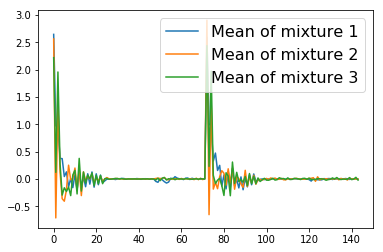

In [46]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

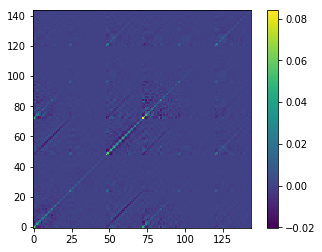

In [47]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

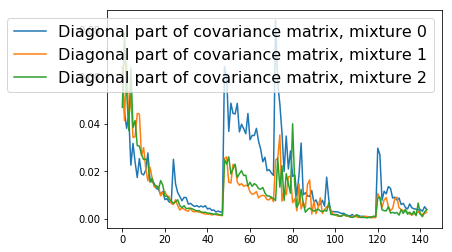

In [48]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5, 
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [49]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    x, frame_sample = librosa.load(src_path, sr=fs, dtype=float64)
    f0, timeaxis = pyworld.dio(x, frame_sample, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, frame_sample)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, frame_sample)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, frame_sample)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, frame_sample, frame_period)
        
    return waveform

Compare results with [this](http://people.tamu.edu/~guanlong.zhao/icassp18_demo.html)

In [50]:
for i, (src_path, tgt_path) in enumerate(zip(src_speaker.test_paths, tgt_speaker.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    src, _ = librosa.load(src_path, sr=fs, dtype=float64)
    tgt, _ = librosa.load(tgt_path, sr=fs, dtype=float64)
    
    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: arctic_a0028.wav


Target: arctic_a0028.wav


w/o MLPG


w/ MLPG


2-th sample
Source: arctic_a0016.wav


Target: arctic_a0016.wav


w/o MLPG


w/ MLPG


3-th sample
Source: arctic_a0024.wav


Target: arctic_a0024.wav


w/o MLPG


w/ MLPG


4-th sample
Source: arctic_a0018.wav


Target: arctic_a0018.wav


w/o MLPG


w/ MLPG


5-th sample
Source: arctic_a0009.wav


Target: arctic_a0009.wav


w/o MLPG


w/ MLPG


6-th sample
Source: arctic_a0010.wav


Target: arctic_a0010.wav


w/o MLPG


w/ MLPG


7-th sample
Source: arctic_a0029.wav


Target: arctic_a0029.wav


w/o MLPG


w/ MLPG


8-th sample
Source: arctic_a0025.wav


Target: arctic_a0025.wav


w/o MLPG


w/ MLPG


9-th sample
Source: arctic_a0013.wav


Target: arctic_a0013.wav


w/o MLPG


w/ MLPG


10-th sample
Source: arctic_a0001.wav


Target: arctic_a0001.wav


w/o MLPG


w/ MLPG
